# Homework 6: Automatic Differentiation, Neural Networks

In this homework, you will start using pytorch and automatic differentiation to train models. 

In [1]:
import numpy as np
import torch
from torch.autograd import grad
from sklearn.datasets import make_regression
import torch.nn as nn
import matplotlib.pyplot as plt

We will work on the same problem as last week. 

In [2]:
x = np.linspace(-10,10,100).reshape(-1,1)

In [3]:
y = 0.1 * x**4 + 1.2 * x**3 + 1.2 * x**2 + 2.1 * x 

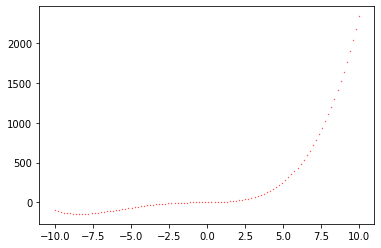

In [4]:
plt.scatter(x,y,color='r',s=0.1)

For your convenience, here is an example showing how to train a linear model by gradient descent.

In [5]:
def model(w,f):
    return lambda x: np.dot(f(x),w)

In [6]:
def f(x):
    return np.concatenate(np.array([x,x**2,x**3,x**4]),axis=1)

In [7]:
def fit(x,y,f,solver):
    w = solver(f(x),y)
    chosen_model = model(w,f)
    plt.scatter(x,y,color='r',s=1.0)
    plt.plot(x,chosen_model(x))

In [8]:
def gradient(X,y,w):
    return -2 * X.T @ y + 2 * X.T @ X @ w

In [9]:
def solve_gd(X,y):
    w = np.array([[2.1],[1],[1],[0]])
    for i in range(1000):
        g = gradient(X,y,w)
        w -= 0.0000000001 * g
     
    return w

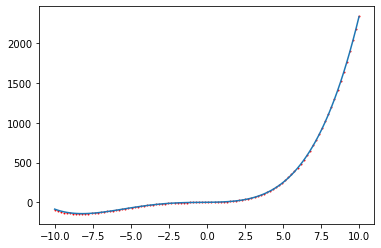

In [10]:
fit(x,y,f,solve_gd)

**Problem 1**: Train the same model, but this time, do it using automatic differentiation. That is, you should **not** use the *gradient* function that was defined above. Instead of calculating the gradient by hand and implementing it, you will compute it automatically. Here are a few hints that will help you:
<ul>
<li> Because it will be used in the *fit* function, your solver will receive numpy arrays as arguments and should return a numpy array. However, your function needs to work using torch tensors. So, the first thing you should do to convert the input to torch tensors, and the last thing you should do is convert the value you want to return back to a numpy array. 
<li> Note that you cannot use the *model* function as we did before, because it works on numpy arrays. You could convert back and forth, but that's too costly. Instead, you should redefine the model so that it uses torch tensors. 
<li> Don't forget that the weights need to be updated for the gradient descent to work, and so you should make sure to define them using the *requires_grad=True* argument.
<li> Even though we have been defining the squared error as a sum of the individual squared errors, you should use the mean.
</ul>

In [11]:
def solve_gd_autodiff(X,y):
    X = torch.tensor(X,dtype=torch.double)
    y = torch.tensor(y,dtype=torch.double)
    w = torch.tensor([[2.1],[1],[1],[0]], requires_grad=True, dtype=torch.double)
    for i in range(10000):
        prediction = X @ w
        error = torch.mean((prediction - y)**2)
        error.backward()
        with torch.no_grad():
            w -= 0.000000001 * w.grad
            w.grad = None
    return w.detach().numpy()

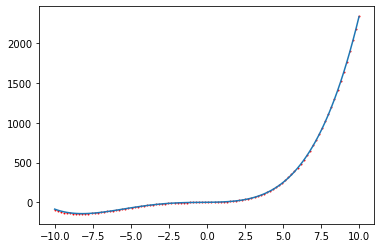

In [12]:
fit(x,y,f,solve_gd_autodiff)

Now, we are going to try solving the same problem again, but using a neural network. That is, instead of combining the projection *f* as before with a linear model, we will try to predict straight from the input value, but with a more powerful neural network. Hopefully, you are starting to see what makes the neural network framework so popular, aside from the fact that it can work so well: no need to clever feature engineering, and thanks to automatic differentiation, no need for any calculus or linear algebra...

Here is the model that you will try to train. A simple neural network with one hidden layer, using the sigmoid function for the non-linearity.

In [13]:
def model(w1,w2,x):
    layer1 = torch.sigmoid(x @ w1)
    return layer1 @ w2

We can print a few random examples of specific instances of this model in the case where we use a single neuron.

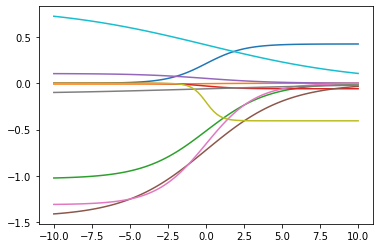

In [14]:
for i in range(10):
    w1 = torch.randn((1,1), requires_grad=True, dtype=torch.double) 
    w2 = torch.randn((1,1), requires_grad=True, dtype=torch.double) 
    y_pred = model(w1,w2,torch.tensor(x))
    y_pred = y_pred.detach().numpy()
    plt.plot(x,y_pred)

Now the same with 100000 neurons. You can see that some of the curve are more complex.

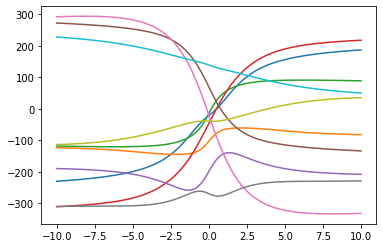

In [15]:
for i in range(10):
    w1 = torch.randn((1,100000), requires_grad=True, dtype=torch.double)
    w1.retain_grad()
    w2 = torch.randn((100000,1), requires_grad=True, dtype=torch.double)
    w2.retain_grad()
    y_pred = model(w1,w2,torch.tensor(x))
    y_pred = y_pred.detach().numpy()
    plt.plot(x,y_pred)

**Problem 2**: Train a neural network model with 1 hidden layer.  Notes:
<ul>
<li> The parameter *alpha* should be used to multiply the gradient.
<li> The parameter *size* should be ussed as the size of the hidden layer.
<li> In this problem, your goal should be to overfit the train set and obtain a train loss of 0. To that end, you should print the error every once in a while. Do not print it at every iteration or you will have a useless flood of information.
<li> This is very difficult, I do not expect you to suceed. However, you should try really hard to reach the lowest possible train loss. 
<li> You should try to think hard about why you keep failing.
</ul>

In [16]:
def solve_gd_autodiff_NN(X,y,alpha,size):
    X = torch.tensor(X,dtype=torch.double)
    y = torch.tensor(y,dtype=torch.double)
    w1 = torch.randn((1,size), requires_grad=True, dtype=torch.double) 
    w2 = torch.randn((size,1), requires_grad=True, dtype=torch.double) 
    for i in range(10000):
        prediction = model(w1,w2,X)
        error = torch.mean((prediction - y)**2)
        if i%1000 == 0:
            print(error)
        error.backward()
        with torch.no_grad():
            w1 -= alpha * w1.grad
            w1.grad = None
            w2 -= alpha * w2.grad
            w2.grad = None
    return (w1,w2)

tensor(378866.4693, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(130924.0710, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(126068.2116, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(124152.8885, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(123059.5985, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(122415.3547, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(122025.1821, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(121763.9025, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(121575.6651, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(121441.7068, dtype=torch.float64, grad_fn=<MeanBackward0>)


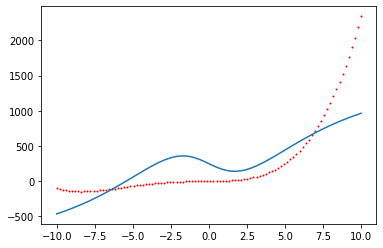

In [17]:
w1, w2 = solve_gd_autodiff_NN(x,y,0.0001,1000)
y_pred = model(w1,w2,torch.tensor(x))
y_pred = y_pred.detach().numpy()
plt.scatter(x,y,color='r',s=1.0)
plt.plot(x,y_pred)
plt.show()